In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Import libraries
import os, glob

import numpy as np
from scipy import integrate
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt 
import matplotlib.cm as cm # colormaps
import matplotlib.colors as mc
import astropy.io.fits as pyfits
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

import pandas as pd
import math 
from astropy.table import Table
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel



from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve_fft
from scipy import ndimage, misc

#import FITS_tools #https://github.com/keflavich/FITS_tools/tree/master/FITS_tools
from reproject import reproject_interp

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
##import the star count maps
star_counts_filename = './FITS/nishiyama_counts.fits'
star_counts = pyfits.open('./FITS/nishiyama_counts.fits')[0]                 
star_counts_wcs = WCS(star_counts.header)

model_counts_filename = './FITS/model_counts.fits'
model_counts = pyfits.open('./FITS/model_counts.fits')[0]                
model_counts_wcs = WCS(model_counts.header)

#import the full cloud catalog mask
full_cloud_cat_mask_filename = '/Users/danilipman/Documents/Research/UConn/3D_CMZ/FITS/id_mask_mosaic_FULL_zeros.fits'
full_cloud_cat_mask = pyfits.open('/Users/danilipman/Documents/Research/UConn/3D_CMZ/FITS/id_mask_mosaic_FULL_zeros.fits')[0]
full_cloud_cat_mask_wcs = WCS(full_cloud_cat_mask.header)


In [4]:
def gaussian_smoothing(res_want, pix_scale, header, data, filename):
    r_eff = 3 #arcmin
    res = (r_eff/2.355) * 60   
    sig_gauss = np.sqrt(res**2 - res_want**2 )
    kern = sig_gauss/pix_scale #arcsec/pix
    
    smoothed = convolve_fft(data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)

    pyfits.writeto('{}_smoothed_reff{}arcmin.fits'.format(filename, r_eff), smoothed, header, overwrite=True) 
    
    return smoothed

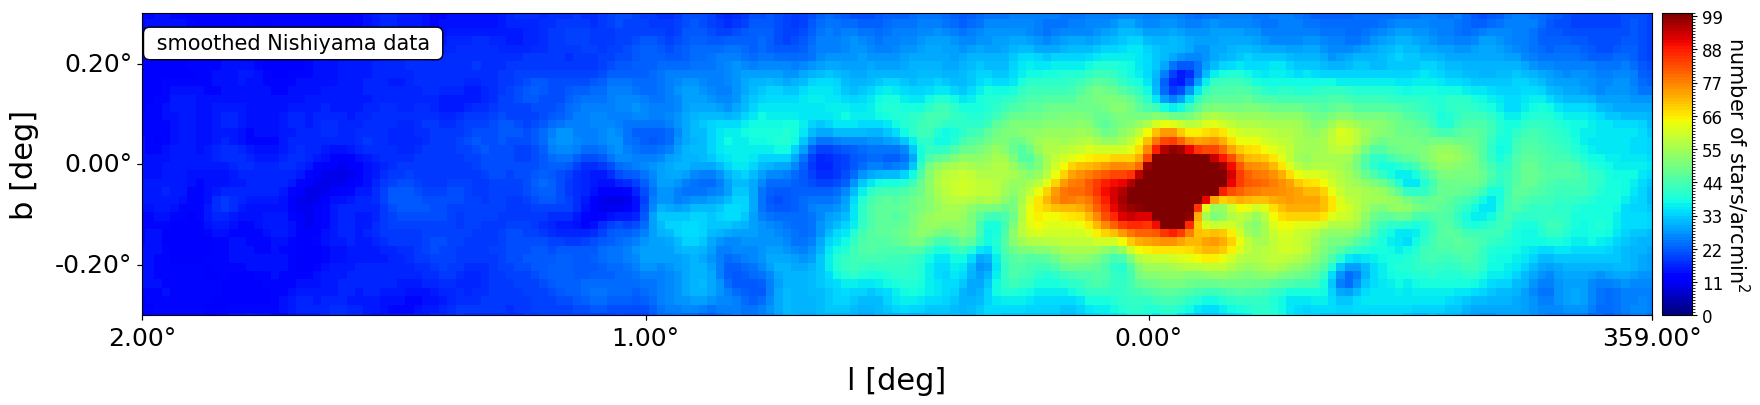

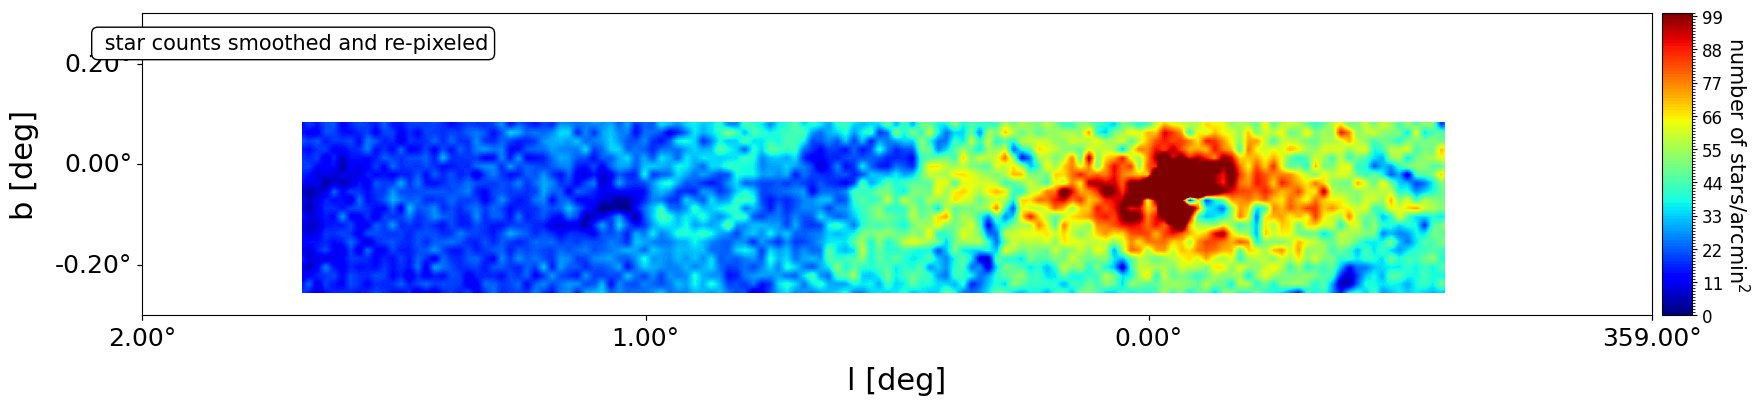

In [5]:
## Smooth the star count map to column density map
sig_colden = 36./2.355 # arcsec
pixscale_colden = 3.2 # arcsec/pix
pixscale_starcount = star_counts.header['CDELT2']*3600
star_count_smoothed = gaussian_smoothing(sig_colden, pixscale_starcount,star_counts.header, star_counts.data, star_counts_filename  )

levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'jet'
#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(2, -0.3, unit="deg", frame='galactic'), star_counts_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-1, 0.3, unit="deg", frame='galactic'), star_counts_wcs)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': star_counts_wcs}, figsize = (20,4), sharex=True, sharey=True)

IM = ax.imshow(star_count_smoothed.data,cmap='jet',norm =norm, origin='lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.1, 0.90, r' smoothed Nishiyama data ', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM, orientation="vertical", cax = cax1)
cb1.set_label(label = r'number of stars/arcmin$^{2}$', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)




## re-pixel smoothed star count, regular star count, and model to column density map (i.e. it matches the mask) 
star_count_smoothed = pyfits.open('{}_smoothed_reff{}arcmin.fits'.format(star_counts_filename, 3))[0]    
star_count_smooth_regrid, regrid_footprint = reproject_interp(star_count_smoothed, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/star_counts_smoothed_conv36arcsec.fits', star_count_smooth_regrid, full_cloud_cat_mask.header, overwrite=True)

star_count_regrid, regrid_footprint = reproject_interp(star_counts, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/star_counts_conv36arcsec.fits', star_count_regrid, full_cloud_cat_mask.header, overwrite=True)



model_count_regrid, regrid_footprint = reproject_interp(model_counts, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/model_counts_conv36arcsec.fits', model_count_regrid, full_cloud_cat_mask.header, overwrite=True)

#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(2, -0.3, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-1, 0.3, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)

IM = ax.imshow(star_count_regrid,cmap='jet',norm =norm, origin='lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.1, 0.90, r' star counts smoothed and re-pixeled', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM, orientation="vertical", cax = cax1)
cb1.set_label(label = r'number of stars/arcmin$^{2}$', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)

In [51]:
#Grab the existing table columns we want 
cat = Table.read('../../3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex')


cat_index = cat['index']
cloud_list = cat['cloud_name']

###just need this file for the multi-comp clouds
large_cat = Table.read('../../3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data_dup.csv')
large_cat_index = large_cat['index']
large_cat_v = large_cat['v']

### For the stddevs, we need to find them for both the single 
### and multi-component clouds separately 
### then combine into the table 

#Find single v component clouds
single_v = {x for x in list(cloud_list) if list(cloud_list).count(x) == 1}


sing_index =[]
for i in range(len(cloud_list)):
    if cloud_list[i] in single_v:
        sing_index.append(i)
        

#find indexes with multiple velocities 
dup = {x for x in list(cloud_list) if list(cloud_list).count(x) > 1}

dup_index =[]
for i in range(len(cloud_list)):
    if cloud_list[i] in dup:
        dup_index.append(i)
        
id_v_list = []
for i in range(len(large_cat_index)):
    id_v_list.append('{}_{}'.format(large_cat_index[i], large_cat_v[i]))
    
    
mask_files=[]
sing_masks_path = '/Users/danilipman/Documents/Research/UConn/3D_CMZ/Cloud_masks/' 
dup_masks_path = '/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks/'
for i in range(len(cat_index)):
    if cat_index[i] in cat_index[sing_index]:
        cloud = cloud_list[i]
        
        if '-' in cloud_list[i]:
            filename = sing_masks_path+cloud_list[i] +'/{}_cutout.fits'.format(cloud_list[i].replace("-", "_"))
        if '+' in cloud_list[i]:
            filename = sing_masks_path+cloud_list[i] +'/{}_cutout.fits'.format(cloud_list[i].replace("+", "_"))
        mask_files.append(filename)
        
    if cat_index[i] in cat_index[dup_index]:
        filename = dup_masks_path+'max/{}_{}_HNCO_cube_max.mask.fits'.format(large_cat_index[i],large_cat_v[i] )
        mask_files.append(filename)

        

    

In [76]:


## import the individual cloud masks and take cutouts
# find the average star count in both the nishiyama regrid and the model regrid 
  
    
cloud_counts_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 
model_counts_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 


counts_tab = Table()
cloud_index = []
cloud_name  = []
cloud_avg_count = []
model_avg_count = []
cloud_min_count = []
model_min_count = []
cloud_stddv = []
model_stddv = []

for i in range(len(mask_files)):
    if cat_index[i]=='16a':
        cloud_index.append(cat_index[i])
        cloud_name.append(cloud_list[i])
        cloud_avg_count.append(np.nan)
        model_avg_count.append(np.nan)
        cloud_min_count.append(np.nan)
        model_min_count.append(np.nan)
        cloud_stddv.append(np.nan)
        model_stddv.append(np.nan)
        continue
            
    hdu_file = pyfits.open(mask_files[i])[0]                
    hdu_wcs = WCS(hdu_file.header)

    
    #regrid to match the map
    mask_regrid, regrid_footprint = reproject_interp(hdu_file, full_cloud_cat_mask.header)
    mask_regrid.astype(int)
    mask_regrid[mask_regrid>0] = 1
    mask_regrid[np.isnan(mask_regrid)==True] = 0

    
    cloud_counts_masked =  np.ma.masked_where(mask_regrid==0, star_count_regrid)
    model_counts_masked =  np.ma.masked_where(mask_regrid==0, model_count_regrid)
    cloud_counts_masked.data[cloud_counts_masked.mask==True] = 0
    model_counts_masked.data[model_counts_masked.mask==True] = 0
    

    
    cloud_index.append(cat_index[i])
    cloud_name.append(cloud_list[i])
    cloud_avg_count.append(np.nanmean(cloud_counts_masked))
    model_avg_count.append(np.nanmean(model_counts_masked))
    cloud_min_count.append(np.nanmin(cloud_counts_masked))
    model_min_count.append(np.nanmin(model_counts_masked))
    cloud_stddv.append(np.nanstd(cloud_counts_masked))
    model_stddv.append(np.nanstd(model_counts_masked))
    
    
    cloud_counts_masked[cloud_counts_masked>0] = np.nanmean(cloud_counts_masked)
    model_counts_masked[model_counts_masked>0] = np.nanmean(model_counts_masked)
    #cloud_counts_masked[cloud_counts_masked>0] = np.median(cloud_counts_masked[np.where(cloud_counts_masked.data!=0)])
    #model_counts_masked[model_counts_masked>0] =np.median(model_counts_masked[np.where(model_counts_masked.data!=0)])
    
    cloud_counts_full_mask+= cloud_counts_masked
    model_counts_full_mask+= model_counts_masked


cloud_counts_full_mask =  np.ma.masked_where(cloud_counts_full_mask==0, cloud_counts_full_mask)
model_counts_full_mask =  np.ma.masked_where(model_counts_full_mask==0, model_counts_full_mask)





counts_tab['cloud_index'] = cloud_index
counts_tab['cloud_name'] = cloud_name
counts_tab['cloud_avg_count'] = cloud_avg_count
counts_tab['model_avg_count'] = model_avg_count
counts_tab['cloud_min_count'] = cloud_min_count
counts_tab['model_min_count'] = model_min_count
counts_tab['counts_ratio_from_avg'] = np.array(cloud_avg_count)/np.array(model_avg_count)
counts_tab['cloud_stddv'] = cloud_stddv
counts_tab['model_stddv'] = model_stddv
counts_tab['counts_ratio_stdv'] = np.sqrt((np.array(cloud_stddv)/np.array(cloud_avg_count))**2 + (np.array(model_stddv)/np.array(model_avg_count))**2 )

counts_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex", overwrite=True)


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_43696/975175871.py:37: RuntimeWarning: invalid value encountered in cast
  mask_regrid.astype(int)


In [77]:
counts_tab

cloud_index,cloud_name,cloud_avg_count,model_avg_count,cloud_min_count,model_min_count,counts_ratio_from_avg,cloud_stddv,model_stddv,counts_ratio_stdv
str3,str14,float64,float64,float64,float64,float64,float64,float64,float64
1,G359.475-0.044,33.519469332369134,38.56380190128456,8.30476883083483,34.78542591524981,0.8691951436264534,9.11366048667291,1.8901537145026583,0.27627405903036906
2,G359.508-0.135,40.71966324848717,36.26453576733873,18.34022255989986,29.668748461459344,1.1228508069076375,8.37557180724044,3.7073298250692357,0.22969288565863505
3,G359.561-0.001,37.12928075077011,43.12310353135302,23.58709869839521,40.528541937983135,0.8610066927064967,7.384794638440922,1.5568531418197495,0.2021441394633493
4a,G359.595-0.223,21.433899361170432,28.972489088933475,4.287319673088132,25.22322401869389,0.7398017924996809,9.232956771374498,1.8994364440876705,0.435724592292387
4b,G359.595-0.223,20.667736464958686,28.23684829490904,4.287319673088132,25.22322401869389,0.7319420442785385,9.736379199192632,1.5292548378413702,0.47419361562471013
5,G359.608+0.018,52.82669110730006,44.76264204318362,42.88904844845227,42.90081461626186,1.1801513202982266,5.248539308821787,0.8760243705680033,0.10126304901427056
6a,G359.688-0.132,55.46299764454641,45.71569028198056,35.60748734825416,41.38484236640031,1.2132157975181639,9.435768811355123,2.386697480984803,0.1779575894283707
6b,G359.688-0.132,59.950447924560926,48.41868858832273,46.792130749759586,43.12547131323056,1.2381675273010047,6.399891458884962,2.647704577313979,0.11994371820387757
7a,G359.701+0.032,54.81721023716828,49.053450594195816,39.405994851496544,45.37342231844451,1.117499575935122,6.516647293470225,2.0898187587651647,0.1262828664271345


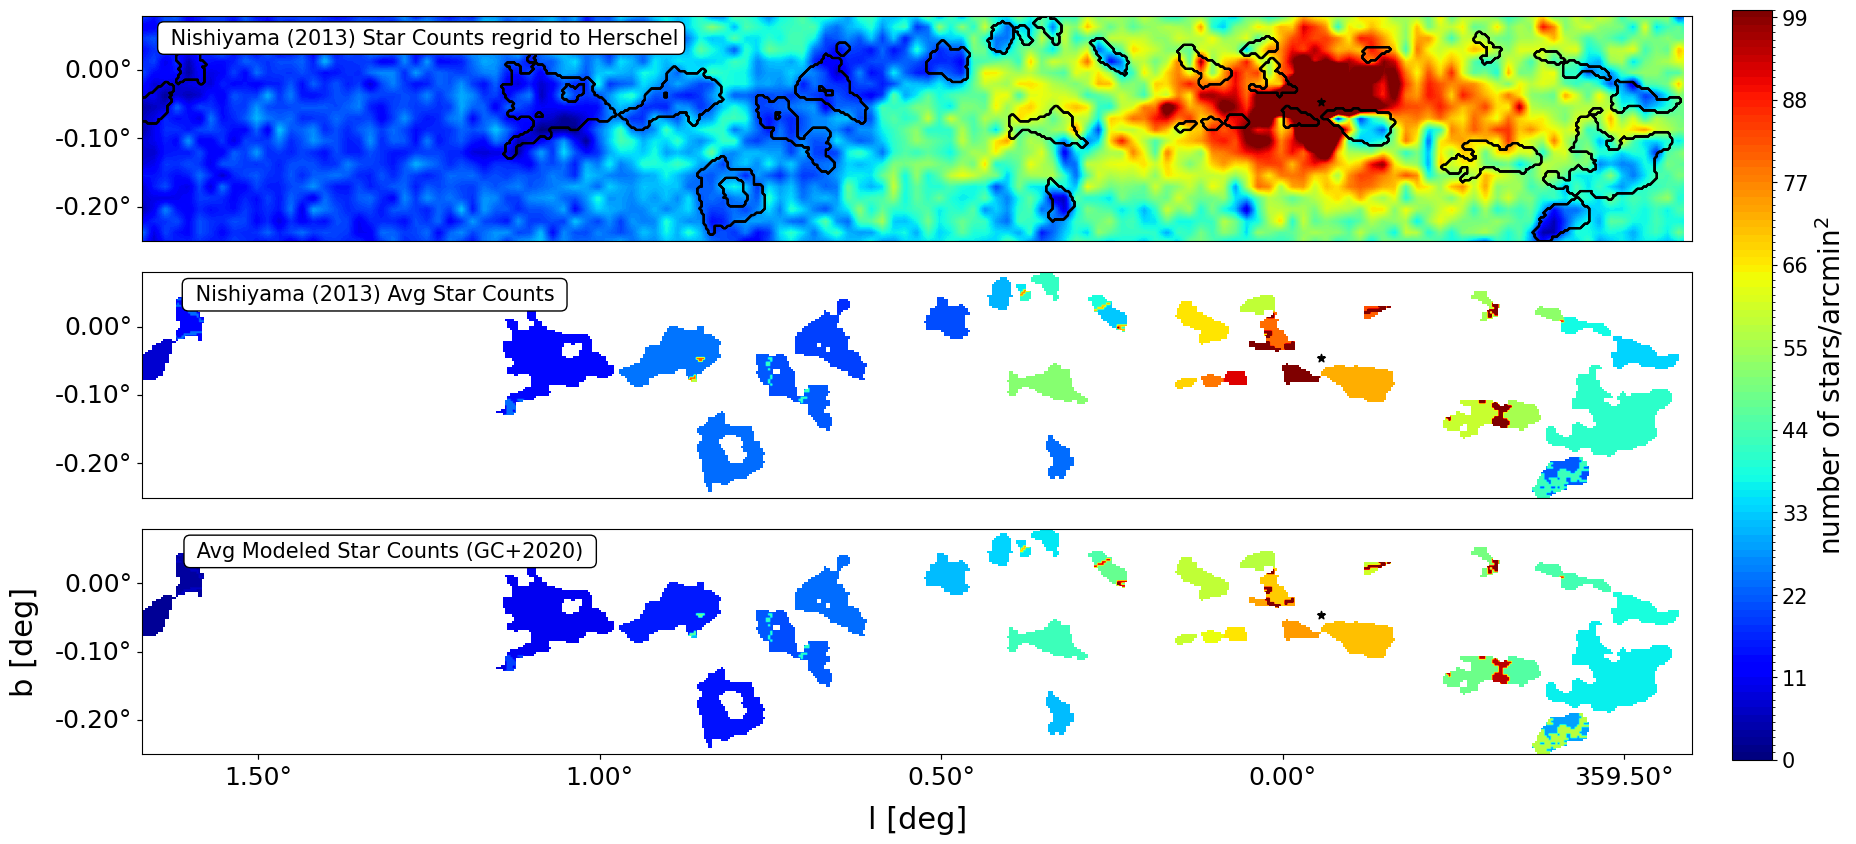

In [78]:
# mask out the star map and the model map 
#counts_masked =  np.ma.masked_where(full_cloud_cat_mask.data==0, star_count_regrid)
#model_masked  = np.ma.masked_where(full_cloud_cat_mask.data==0, model_count_regrid)

###PLOT###

levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'jet'
#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(1.67, -0.25, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.6, 0.08, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)



fig, ax = plt.subplots(nrows=3, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)


IM0 = ax[0].imshow(star_count_regrid,norm=norm,cmap=cmap,origin='lower')
ax[0].contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)


lon = ax[0].coords[0]
lat = ax[0].coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

ax[0].set_xlabel(' ')
ax[0].set_ylabel(' ')
ax[0].tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax[0].tick_params(labelsize=18) 
ax[0].set_xlim(ext_min[0],ext_max[0])
ax[0].set_ylim(ext_min[1],ext_max[1])
ax[0].text(0.18, 0.90, r' Nishiyama (2013) Star Counts regrid to Herschel', ha='center', va='center', transform=ax[0].transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)



IM1 = ax[1].imshow(cloud_counts_full_mask,norm=norm,cmap=cmap,origin='lower')

lon = ax[1].coords[0]
lat = ax[1].coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

ax[1].set_xlabel(' ')
ax[1].set_ylabel(' ')
ax[1].tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax[1].tick_params(labelsize=18) 
ax[1].set_xlim(ext_min[0],ext_max[0])
ax[1].set_ylim(ext_min[1],ext_max[1])
ax[1].text(0.15, 0.90, r' Nishiyama (2013) Avg Star Counts ', ha='center', va='center', transform=ax[1].transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)



IM2 = ax[2].imshow(model_counts_full_mask,norm=norm,cmap=cmap,origin='lower')


lon = ax[2].coords[0]
lat = ax[2].coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax[2].set_xlabel('l [deg]',fontsize=22)
ax[2].set_ylabel('b [deg]',fontsize=22)
ax[2].set_xlim(ext_min[0],ext_max[0])
ax[2].set_ylim(ext_min[1],ext_max[1])
ax[2].tick_params(labelsize=18) 
ax[2].text(0.16, 0.90, r' Avg Modeled Star Counts (GC+2020) ', ha='center', va='center', transform=ax[2].transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
ax[0].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[0].get_transform('world'))
ax[1].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[1].get_transform('world'))
ax[2].scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax[2].get_transform('world'))

cax = fig.add_axes([0.92, 0.12, 0.02, .75,])
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    spacing='proportional',
    orientation='vertical',

)
cb.ax.tick_params(labelsize=15)  # set your label size here
cb.set_label(r'number of stars/arcmin$^{2}$', fontsize=20,)




# take ratio of the two
# define some percentage of extincted stars that count as "near side"
## could we do a distance-based thing with this? similar to the typial MIR techniques?


In [79]:
# Create a ratio similar to the flux ratio?
# will need the minimum star count in both SgrB2 and the Brick?


brick_ind = np.where(counts_tab['cloud_name'] == 'G0.255+0.02')[0][0]
sgrb2_ind = np.where(counts_tab['cloud_name'] == 'G0.666-0.028')[0][0]

brick_cnt_min = counts_tab['cloud_min_count'][brick_ind]
sgrb2_cnt_min = counts_tab['cloud_min_count'][sgrb2_ind]

brick_mod_min = counts_tab['model_min_count'][brick_ind]
sgrb2_mod_min = counts_tab['model_min_count'][sgrb2_ind]

stcnt_avg = (brick_cnt_min + sgrb2_cnt_min)/2
model_stcnt_avg = (brick_mod_min + sgrb2_mod_min)/2

ratio_avg = stcnt_avg/model_stcnt_avg

print(stcnt_avg, model_stcnt_avg)

15.188278861089406 31.3087979876967


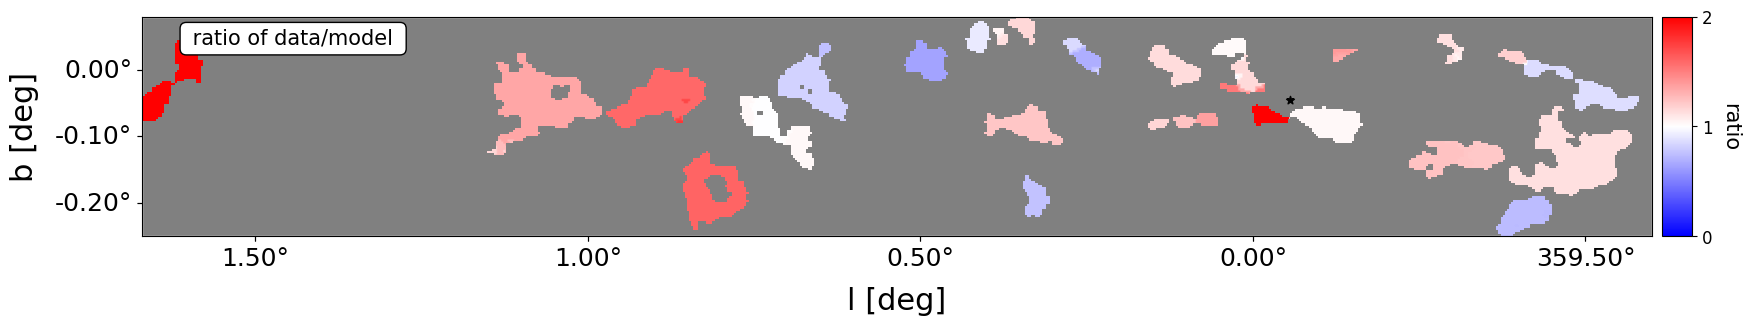

In [80]:
count_ratio = (cloud_counts_full_mask)/(model_counts_full_mask)



cmap    = 'bwr'
#divnorm =mc.TwoSlopeNorm(vmin=np.min(count_ratio), vcenter=1, vmax=np.max(count_ratio))
divnorm =mc.TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)
ax.set_facecolor('gray')

IM1 = ax.imshow(count_ratio,cmap=cmap,origin='lower', norm=divnorm)


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.1, 0.90, r' ratio of data/model ', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
ax.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax.get_transform('world'))

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM1, orientation="vertical", cax = cax1,ticks=[0., 1., 2]  )
cb1.set_label(label = r'ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)


In [81]:
###create normalization for ratio
count_ratio_list = np.array(cloud_avg_count)/np.array(model_avg_count)

countratio_cn = 2. * ((1 - 0) / (2 - 0)) - 1.

countratio_normed = []

for i in range(len(count_ratio_list)):
    
    ### NORMING 
    z_countratio_i = 2. * ((count_ratio_list[i] - 0) / (2- 1) )- 1.
    countratio_normed.append(z_countratio_i-countratio_cn) 
    


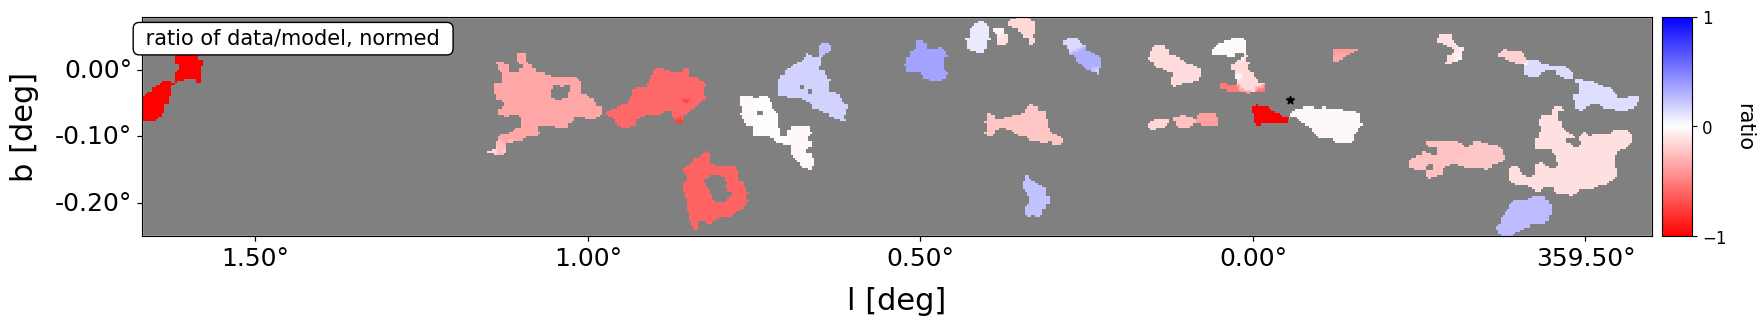

In [84]:
##plot the normed map
count_ratio_masked =  np.ma.masked_where(count_ratio.data==0, count_ratio)

countratio_map_normed = -(2. * ((count_ratio - 0) / (2 - 0)) - 1.)-countratio_cn



cmap    = 'bwr_r'
divnorm =mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)
ax.set_facecolor('gray')

IM1 = ax.imshow(countratio_map_normed,cmap=cmap,origin='lower', norm=divnorm)


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.1, 0.90, r' ratio of data/model, normed ', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
ax.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax.get_transform('world'))

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM1, orientation="vertical", cax = cax1,ticks=[-1., 0., 1]  )
cb1.set_label(label = r'ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)

